In [ ]:
import tensorflow as tf
import os
import pathlib
import time
import datetime
from matplotlib import pyplot as plt
from IPython import display

#Image Loading


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#dataset='facades'
#path=f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset}.tar.gz'
#drive_path='/content/drive/My Drive/dataset/facades'

In [ ]:
#path_to_zip = tf.keras.utils.get_file(fname=f"{dataset}.tar.gz",origin=path,extract=True)
#path_to_zip  = pathlib.Path(path_to_zip)

In [ ]:
#PATH = path_to_zip.parent/'night2day'
PATH='/content/drive/My Drive/dataset/night2day'
#'/content/drive/My Drive/dataset/night2day'
pics=os.listdir(PATH)
len(pics)

4

In [ ]:
sample_image = tf.io.read_file(str(PATH+'/train1/101_8566_to_8549.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


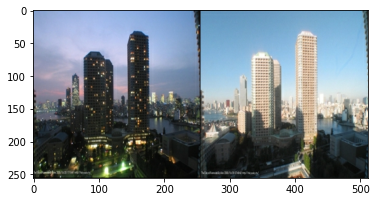

In [ ]:
plt.figure()
plt.imshow(sample_image)

In [ ]:
def load(img_file):
  img = tf.io.read_file(img_file)
  img = tf.io.decode_jpeg(img)

  w=tf.shape(img)[1]
  w=w//2#return int

  input_img=img[:,w:,:]
  real_img=img[:,:w,:]

  input_img = tf.cast(input_img, tf.float32)
  real_img= tf.cast(real_img, tf.float32)
  return input_img,real_img

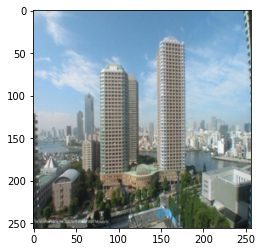

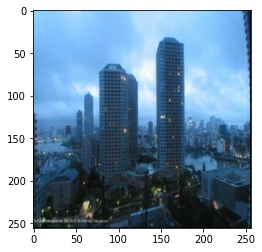

In [ ]:
input, re = load(str(PATH +'/train1/101_8561_to_8521.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(input /255.0 )#imshow 会把所有大于1的double 识别是白色
plt.figure()
plt.imshow(re / 255.0)


In [ ]:
BUFFER_SIZE =521#night2day171. #400for facde
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image, real_image

In [ ]:
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image[0],cropped_image[1]

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
  input_image, real_image = resize(input_image, real_image, 286, 286)  # Resizing to 286x286
  input_image, real_image = random_crop(input_image, real_image)  # Random cropping back to 256x256
  if tf.random.uniform(()) > 0.5:    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
  return input_image, real_image

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


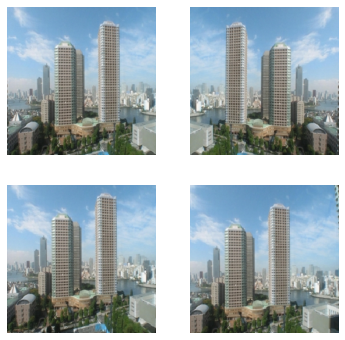

In [ ]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(input, re)
  print(rj_inp.shape)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(PATH + '/train1/*.jpg'))
train_dataset = train_dataset.map(load_image_train,num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
print(train_dataset)


<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>


In [ ]:
test_dataset = tf.data.Dataset.list_files(str(PATH + '/test/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

#Unet

In [ ]:
OUTPUT_CHANNELS = 3

In [ ]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
down_model = downsample(64, 3)
print(input.shape)
down_result = down_model(tf.expand_dims(input, 0))#3个filter，卷积核的大小是3*3
print (down_result.shape)

(256, 256, 3)
(1, 128, 128, 64)


In [ ]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)
  result = tf.keras.Sequential()
  result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2,padding='same',kernel_initializer=initializer,use_bias=False))
  result.add(tf.keras.layers.BatchNormalization())
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
  result.add(tf.keras.layers.ReLU())
  return result

In [ ]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


# 


In [ ]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])
  down_stack = [
    downsample(64, 3, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 3),  # (batch_size, 64, 64, 128)
    downsample(256, 3),  # (batch_size, 32, 32, 256)
    downsample(512, 3),  # (batch_size, 16, 16, 512)
    downsample(512, 3),  # (batch_size, 8, 8, 512)
    downsample(512, 3),  # (batch_size, 4, 4, 512)
    downsample(512, 3),  # (batch_size, 2, 2, 512)
    downsample(512, 3),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 3, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 3, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 3, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 3),  # (batch_size, 16, 16, 1024)
    upsample(256, 3),  # (batch_size, 32, 32, 512)
    upsample(128, 3),  # (batch_size, 64, 64, 256)
    upsample(64, 3),  # (batch_size, 128, 128, 128)
  ]
  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same',kernel_initializer=initializer,activation='tanh')  
  x = inputs
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)
  skips = reversed(skips[:-1])
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])
  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

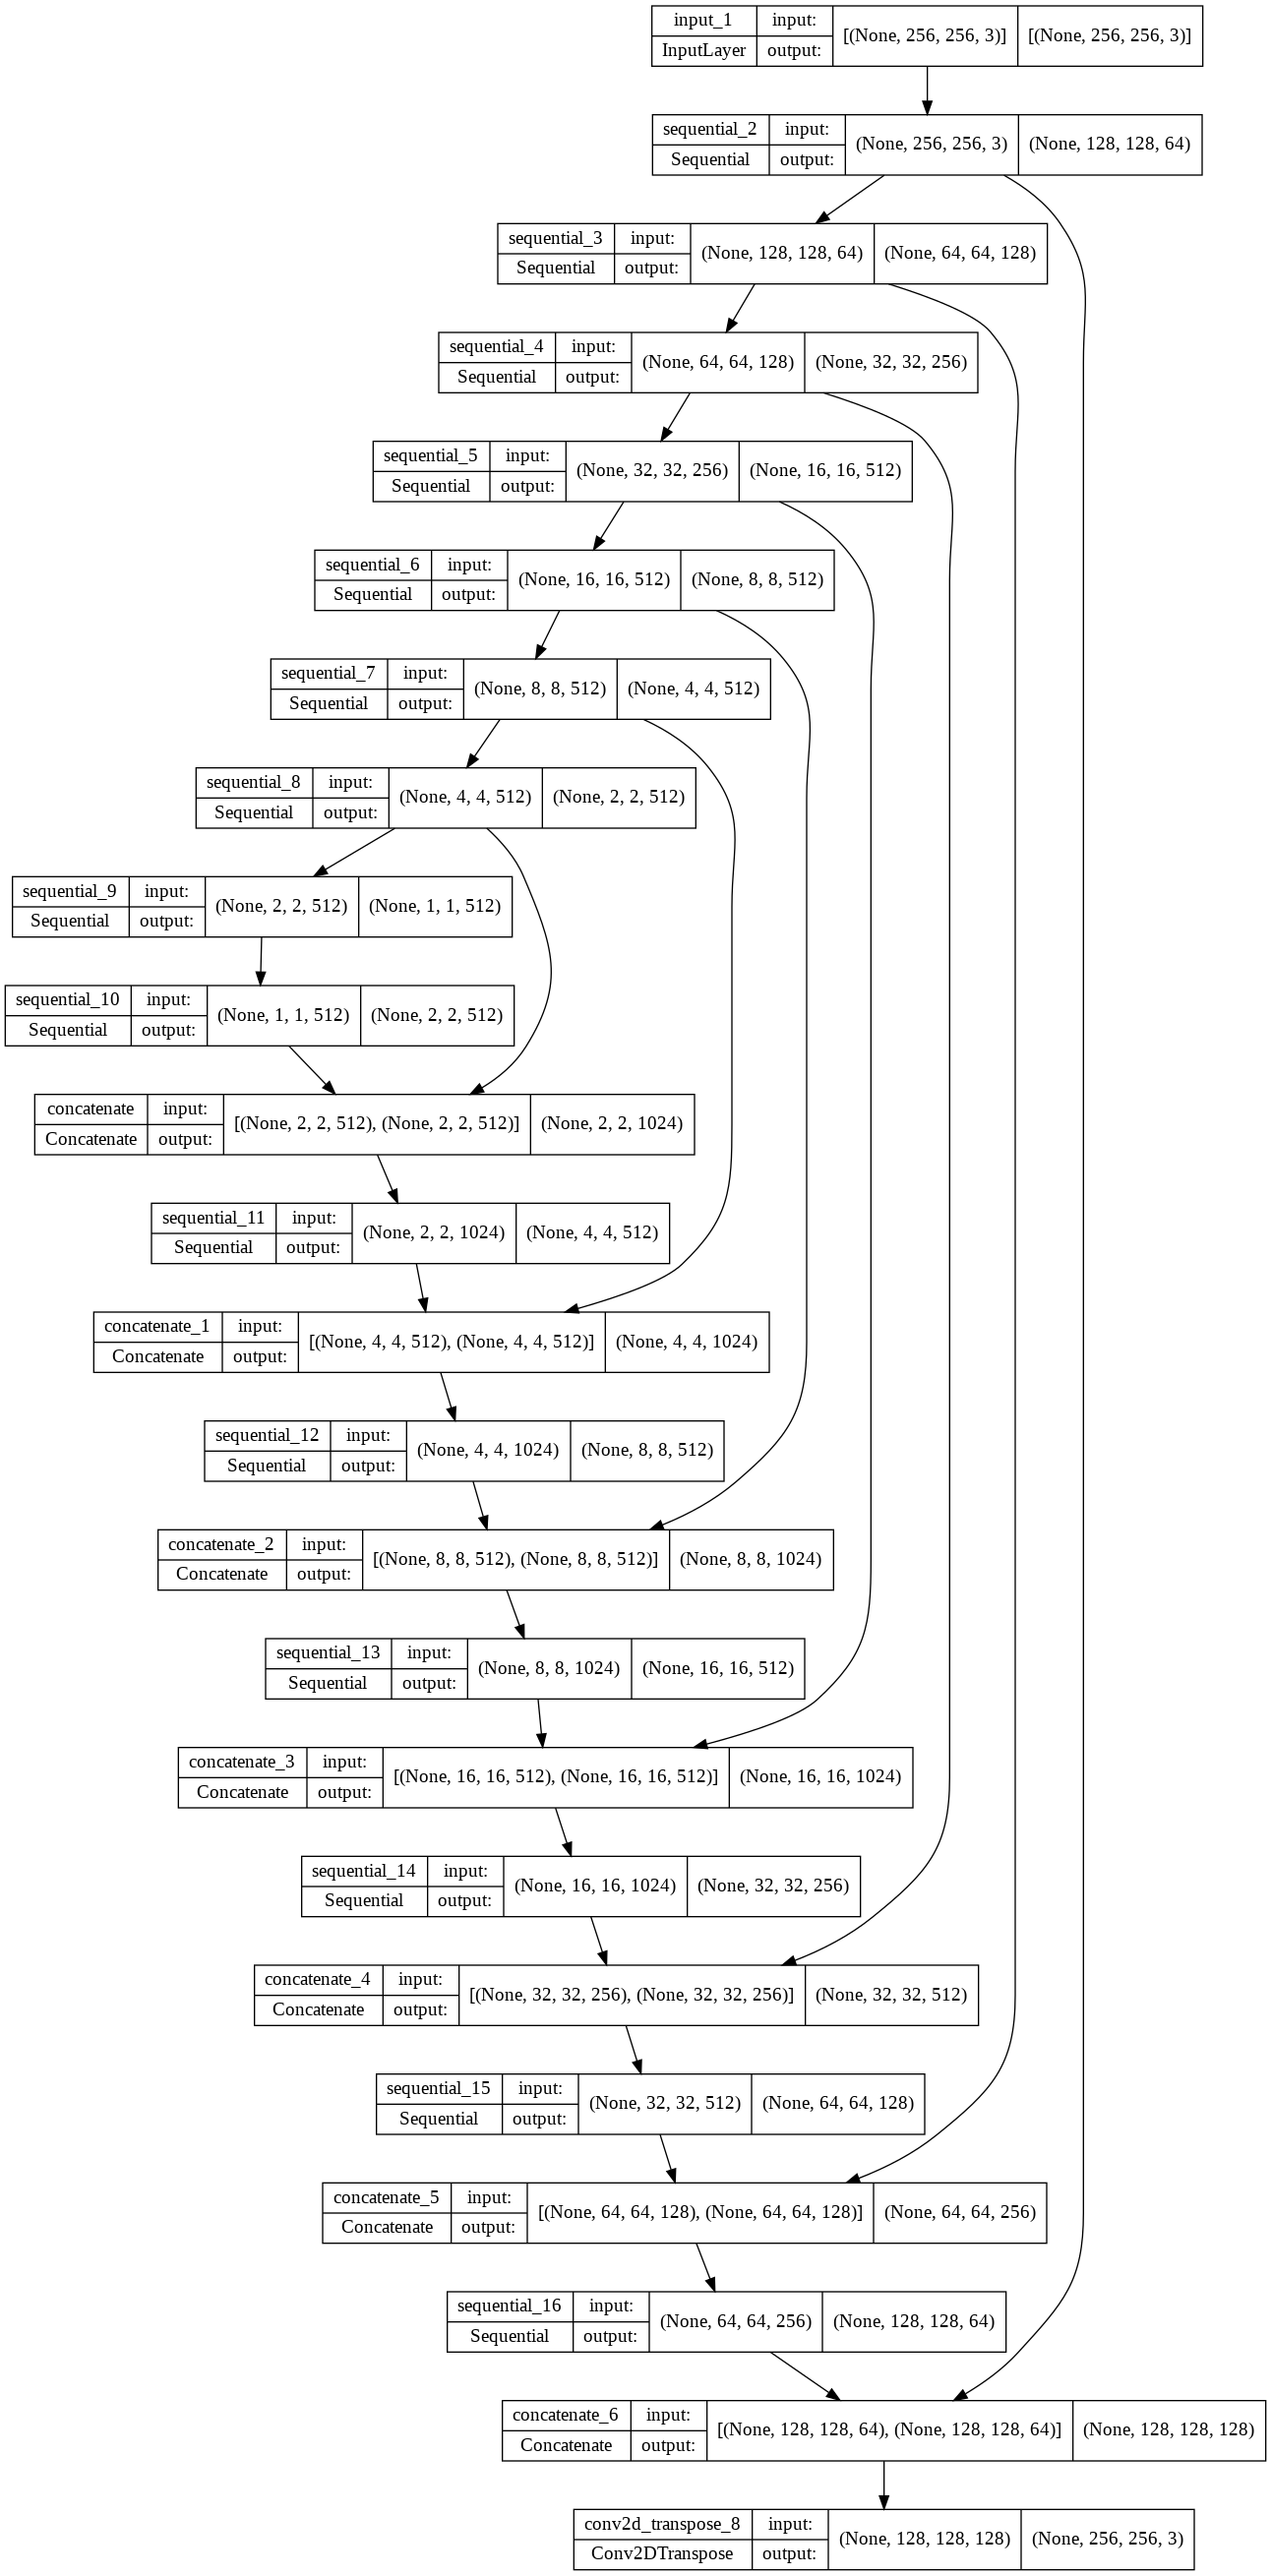

In [ ]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True)

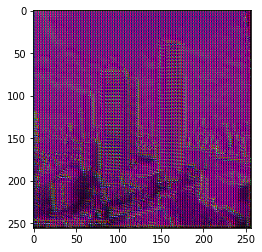

In [ ]:
gen_output = generator(input[tf.newaxis, ...], training=False)
import numpy as np
plt.imshow(np.clip(gen_output[0,...],0,255))

In [ ]:
LAMBDA = 100
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
  #l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  l2_loss = tf.reduce_mean(tf.square(target-gen_output))
  #l3_loss = tf.reduce_mean(tf.math.pow(tf.abs(target-gen_output),3))
  total_gen_loss = gan_loss + (LAMBDA * l2_loss)
  return total_gen_loss, gan_loss, l2_loss

In [ ]:
def Discriminator():
  initializer = tf.random_normal_initializer(0.,0.02)
  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')
  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)
  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)
  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,kernel_initializer=initializer,use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)
  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)
  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)
  last = tf.keras.layers.Conv2D(1, 4, strides=1,kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
  return tf.keras.Model(inputs=[inp, tar], outputs=last)

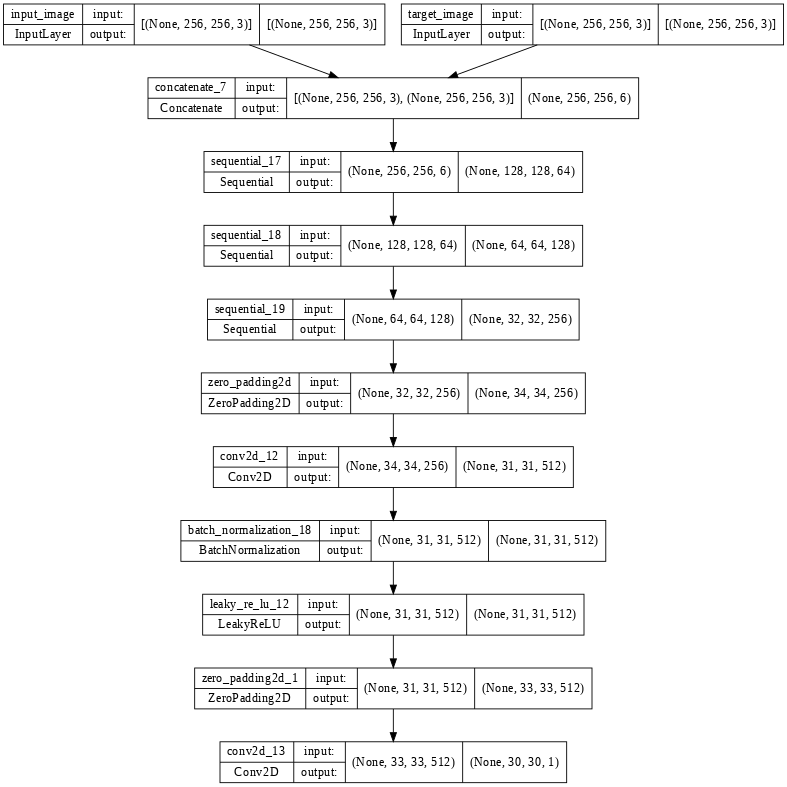

In [ ]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

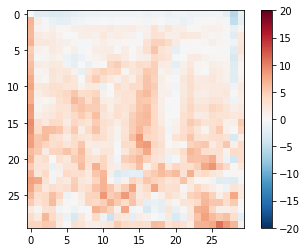

In [ ]:
disc_out = discriminator([input[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

In [ ]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  total_disc_loss = real_loss + generated_loss
  print(generated_loss)
  return total_disc_loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,discriminator_optimizer=discriminator_optimizer,generator=generator,discriminator=discriminator)

In [ ]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

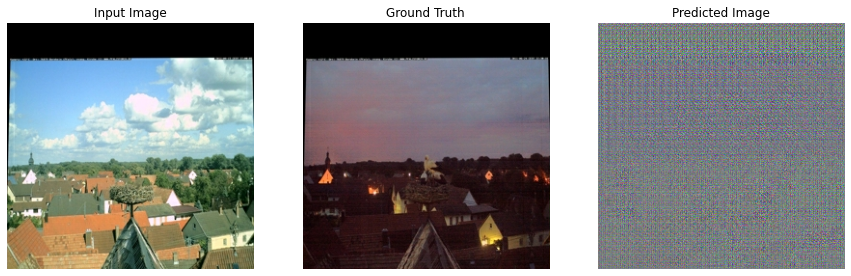

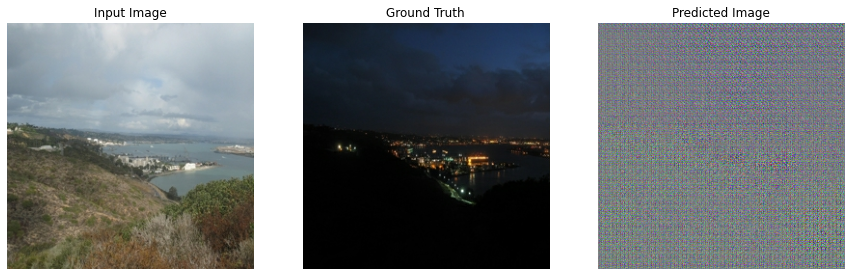

In [ ]:
for example_input, example_target in test_dataset.take(2):
  generate_images(generator, example_input, example_target)

In [ ]:
log_dir="logs/"
summary_writer = tf.summary.create_file_writer(log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)
    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)
    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
  generator_gradients = gen_tape.gradient(gen_total_loss,generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))
  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

In [ ]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()
  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)
      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')
      start = time.time()
      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")
    train_step(input_image, target, step)
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)#checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

#main

In [ ]:
kth='/content/drive/My Drive/dataset/kth.jpg'

In [ ]:
def load_kth(img_file):
  img = tf.io.read_file(img_file)
  img = tf.io.decode_jpeg(img)
  input_img = tf.cast(img, tf.float32)
  return input_img
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
def resize_kth(input_image, height, width):
  input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  return input_image
def normalize_kth(input_image):
  input_image = (input_image / 127.5) - 1
  return input_image

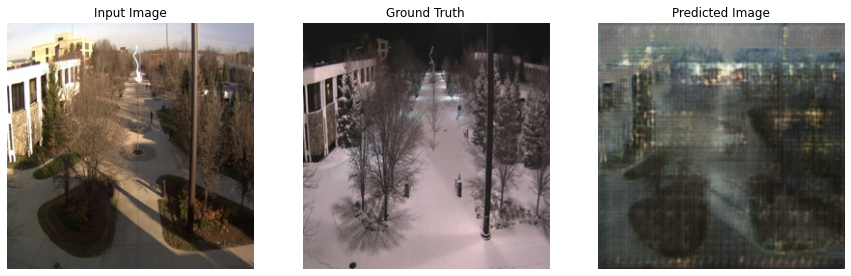

Step: 10k
................................................

In [ ]:
fit(train_dataset, test_dataset, steps=40000)


In [ ]:
input_image= load_kth(kth)
input_kth= resize_kth(input_image,IMG_HEIGHT, IMG_WIDTH)
input_kth= normalize_kth(input_kth)


NameError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


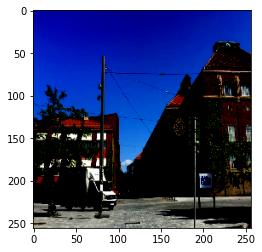

In [ ]:
plt.imshow(input_kth)

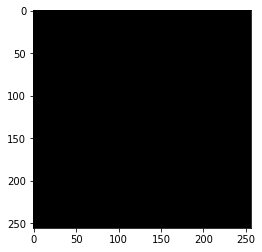

In [ ]:
gen_output = generator(input_kth[tf.newaxis, ...], training=False)
import numpy as np
plt.imshow(np.clip(gen_output[0,...],0,255))